In [63]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [64]:
data = pd.read_csv('./data/gender-classifier-DFE-791531.csv'
                   ,header = 0
                   ,error_bad_lines=False
                   ,encoding='latin1'
                   ,skip_blank_lines=True)

In [65]:
# _unit_id(唯一ID): a unique id for user
# _golden(黄金标准，2值): whether the user was included in the gold standard for the model; TRUE or FALSE
# _unit_state(检测状态，2值): state of the observation; one of finalized (for contributor-judged) or golden (for gold standard observations)
# _trusted_judgments(可信的评论数量，连续值): number of trusted judgments (int); always 3 for non-golden, and what may be a unique id for gold standard observations
# _last_judgment_at(最后评论时间): date and time of last contributor judgment; blank for gold standard observations
# gender(性别): one of male, female, or brand (for non-human profiles)
# gender:confidence(性别的可信度，置信区间): a float representing confidence in the provided gender
# profile_yn(no代表是资料收集，非预测): "no" here seems to mean that the profile was meant to be part of the dataset but was not available when contributors went to judge it
# profile_yn:confidence(profile_yn置信取间): confidence in the existence/non-existence of the profile
# created(用户创建时间): date and time when the profile was created
# description(用户描述): the user's profile description
# fav_number(关注人数): number of tweets the user has favorited
# gender_gold(性别 黄金？): if the profile is golden, what is the gender?
# link_color(十六进制，link颜色): the link color on the profile, as a hex value
# name(名称): the user's name
# profile_yn_gold(二值): whether the profile y/n value is golden
# profileimage（头像）: a link to the profile image
# retweet_count(被关注次数): number of times the user has retweeted (or possibly, been retweeted)
# sidebar_color(边框颜色): color of the profile sidebar, as a hex value
# text(随机抽取的tweets文本): text of a random one of the user's tweets
# tweet_coord(如果用户开启了定位，则显示经纬度): if the user has location turned on, the coordinates as a string with the format "[latitude, longitude]"
# tweet_count(发布的tweet数): number of tweets that the user has posted
# tweet_created(随机抽取的tweet创建时间): when the random tweet (in the text column) was created
# tweet_id(随机抽取的tweet的id): the tweet id of the random tweet
# tweet_location(tweet的定位，没有做规范化处理): location of the tweet; seems to not be particularly normalized
# user_timezone(用户的时区): the timezone of the user

In [66]:
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,...,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,...,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,...,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,...,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,...,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,...,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN


In [67]:
##拿到y值
series_female = data['gender'] == 'female'
series_male = data['gender'] == 'male'
series_brand = data['gender'] == 'brand'

df_female = data[series_female]
df_male = data[series_male]
df_brand = data[series_brand]

#三种性别的个数
print(f'Gender - female: {df_female["gender"].count()}')
print(f'Gender - male: {df_male["gender"].count()}')
print(f'Gender - brand: {df_brand["gender"].count()}')

#将性别进行人工编码，female=0，male=1， brand=2
df_female.gender = 0
df_male.gender = 1
df_brand.gender = 2

#合并y值结果数据,行合并，ignore_index=True，默认columns相同，index纵向相加，若列合并，axis=1,但列数量必须相同
df = pd.concat([df_female, df_male, df_brand], ignore_index=True)

Gender - female: 6700
Gender - male: 6194
Gender - brand: 5942


In [70]:
#寻找x的特征，性别判别，先直观圈选
# + (_golden) golden标准，二值，估计是一种荣耀徽章之类的？
# + (_trusted_judgments) 可信的评论数量，男女品牌 评论数理论上应该不同吧。
# + (description) 个人简介，太有用了，但是是text文本，需要加大处理力度了。
# + (fav_number) 关注人数，男女品牌关注行为可能不同。
# + (gender_gold) 性别 黄金？什么鬼
# + (link_color) link颜色，颜色一向跟性别强相关，拿下先。
# + (name) 名称，理论上是有差别的。
# + (retweet_count) 被关注数？女性 跟品牌 容易被关注？
# + (sidebar_color) 头像边框颜色，理论上还是有特征差异的。
# + (text) 随机抽取的一条推文，推文理论上能一定程度反应，但量应该多点。
# + (tweet_coord) 开启定位，如果开启则显示经纬度，可以考虑做成二值特征。
# + (tweet_count) 推文数量，不同性别这个指标活跃度不同？
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18836 entries, 0 to 18835
Data columns (total 26 columns):
_unit_id                 18836 non-null int64
_golden                  18836 non-null bool
_unit_state              18836 non-null object
_trusted_judgments       18836 non-null int64
_last_judgment_at        18786 non-null object
gender                   18836 non-null int64
gender:confidence        18836 non-null float64
profile_yn               18836 non-null object
profile_yn:confidence    18836 non-null float64
created                  18836 non-null object
description              15522 non-null object
fav_number               18836 non-null int64
gender_gold              50 non-null object
link_color               18836 non-null object
name                     18836 non-null object
profile_yn_gold          50 non-null object
profileimage             18836 non-null object
retweet_count            18836 non-null int64
sidebar_color            18836 non-null object
text     

In [71]:
##由于特征中包含了文本属性，文本的特征性，且信息区分度可能更高，进行优先处理
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn import preprocessing

##文本预处理函数,符号移除，大小写转换
import re
from sklearn.model_selection import train_test_split

In [72]:
def normalize_text(s, type):
    s = str(s)
    s = s.lower()
    s = re.sub('\s\W', ' ', s)
    s = re.sub('\W\s', ' ', s)
    s = re.sub('\s+', ' ', s)
    s = re.sub('[^a-zA-Z]',' ', s)
    if (type == 'name'):
        s = re.sub('_', ' ', s)
    return s.strip()

df['description_norm'] = [normalize_text(s,'description') for s in df['description']]
df['name_norm'] = [normalize_text(s,'name') for s in df['name']]
df['text_norm'] = [normalize_text(s,'text') for s in df['text']]

y = df['gender']
df['description'] = df['description'].fillna(" ")

In [73]:
def print_score(y_t, y_p, confusion):
    text_accuracy = accuracy_score(y_t, y_p)

    text_0_recall  = confusion[0,0]/(confusion[0,0]+confusion[0,1]+confusion[0,2])
    text_0_precision = confusion[0,0]/(confusion[0,0]+confusion[1,0]+confusion[2,0])
    text_1_recall  = confusion[1,1]/(confusion[1,0]+confusion[1,1]+confusion[1,2])
    text_1_precision = confusion[1,1]/(confusion[0,1]+confusion[1,1]+confusion[2,1])
    text_2_recall  = confusion[2,2]/(confusion[2,0]+confusion[2,1]+confusion[2,2])
    text_2_precision = confusion[2,2]/(confusion[0,2]+confusion[1,2]+confusion[2,2])

    text_avg_precision = (text_0_precision+text_1_precision+text_2_precision)/3
    text_avg_recall = (text_0_recall+text_1_recall+text_2_recall)/3

    print(f'0-precision: {text_0_precision}')
    print(f'0-recall: {text_0_recall}')

    print(f'1-precision: {text_1_precision}')
    print(f'1-recall: {text_1_recall}')

    print(f'2-precision: {text_2_precision}')
    print(f'2-recall: {text_2_recall}')

    print(f'avg-precison: {text_avg_precision}')
    print(f'avg-recall: {text_avg_recall}')
    print(f'accuracy: {text_accuracy}')

In [74]:
###使用文本进行模型训练
from sklearn.naive_bayes import MultinomialNB,BernoulliNB

c_vec_s = CountVectorizer(analyzer='word',stop_words='english')
df_text = pd.concat([df['description_norm'], df['name_norm'] , df['text_norm']], axis=1)
# 要做类型转换

x_text_count = c_vec_s.fit_transform((df['text']+df['description']).tolist()) 
# x_text_count = c_vec_s.fit_transform((df['text_norm']+df['description_norm']).tolist()) 
x_train, x_test, y_train, y_test = train_test_split(x_text_count, y, test_size = 0.35)

#贝叶斯
nb = BernoulliNB()
nb.fit(x_train, y_train)

y_predict = nb.predict(x_test)
text_confusion = confusion_matrix(y_test, y_predict,labels=[0,1,2])
print(f'confusion_matrix: \n{text_confusion}')

print_score(y_test, y_predict, text_confusion)

x_train.shape

confusion_matrix: 
[[2015  189  104]
 [1271  720  209]
 [ 567  193 1325]]
0-precision: 0.5229691149753439
0-recall: 0.8730502599653379
1-precision: 0.6533575317604355
1-recall: 0.32727272727272727
2-precision: 0.8089133089133089
2-recall: 0.6354916067146283
avg-precison: 0.6617466518830295
avg-recall: 0.6119381979842312
accuracy: 0.6158046412862126


(12243, 66195)

In [75]:
###试图优化text维度的模型，从以下几个方面优化
#+ 特征处理，弃用countvector，采用tfidf
#+ 贝叶斯的参数
#+ 更换模型

In [83]:
#使用tfidf
t_vec_s = TfidfVectorizer(analyzer='word',stop_words='english')
# text_t_x = t_vec_s.fit_transform((df['text_norm']+df['description_norm']).tolist()) 
x_text_tfidf = t_vec_s.fit_transform((df['text']+df['description']).tolist()) 

x_train, x_test, y_train, y_test = train_test_split(x_text_tfidf, y, test_size = 0.35)

#贝叶斯
nb_t = BernoulliNB()
nb_t.fit(x_train, y_train)
y_predict = nb_t.predict(x_test)
text_confusion = confusion_matrix(y_test, y_predict,labels=[0,1,2])
print(f'confusion_matrix: \n{text_confusion}')
print_score(y_test,y_predict,text_confusion)

confusion_matrix: 
[[2000  230   86]
 [1252  737  195]
 [ 567  208 1318]]
0-precision: 0.5236973029588897
0-recall: 0.8635578583765112
1-precision: 0.6272340425531915
1-recall: 0.3374542124542125
2-precision: 0.8242651657285803
2-recall: 0.6297181079789775
avg-precison: 0.6583988370802204
avg-recall: 0.610243392936567
accuracy: 0.6150462611861065


In [84]:
#更换count的NB算法
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC

x_train, x_test, y_train, y_test = train_test_split(x_text_count, y, test_size = 0.35)

print(x_train.shape)
#贝叶斯
model = LogisticRegressionCV()
model.fit(x_train, y_train)

y_predict = model.predict(x_test)
text_confusion = confusion_matrix(y_test, y_predict,labels=[0,1,2])
print(f'confusion_matrix: \n{text_confusion}')

print_score(y_test, y_predict, text_confusion)

#SVM
model = SVC()
model.fit(x_train, y_train)

y_predict = model.predict(x_test)
text_confusion = confusion_matrix(y_test, y_predict,labels=[0,1,2])
print(f'confusion_matrix: \n{text_confusion}')

print_score(y_test, y_predict, text_confusion)

(12243, 66195)
confusion_matrix: 
[[1653  529  171]
 [ 796 1092  272]
 [ 319  338 1423]]
0-precision: 0.5971820809248555
0-recall: 0.7025074373140672
1-precision: 0.557427258805513
1-recall: 0.5055555555555555
2-precision: 0.762593783494105
2-recall: 0.6841346153846154
avg-precison: 0.6390677077414911
avg-recall: 0.630732536084746
accuracy: 0.632185651448506
confusion_matrix: 
[[2353    0    0]
 [2160    0    0]
 [2080    0    0]]
0-precision: 0.3568936751099651
0-recall: 1.0
1-precision: nan
1-recall: 0.0
2-precision: nan
2-recall: 0.0
avg-precison: nan
avg-recall: 0.3333333333333333
accuracy: 0.3568936751099651


In [85]:
##count和tfidf对比来看
# + tfidf的对应recall稍微差点，precision好点
# + 整体差异不明显，但对于female类型 较显著
# + 从整体的角度看，male的precision和recall都比较差，female和brand效果勉强

In [86]:
#特征与y的分布，构建一个散点分布函数

def drawScatter(x, y, xLabel):
    plt.figure(figsize=(10,5))
    plt.scatter(x, y)
    plt.title('%s VS Gender' %xLabel)
    plt.xlabel(xLabel)
    plt.ylabel('Gender')
    plt.yticks(range(0, 2, 1)) # 纵轴起点，最大值，间隔, 对应的就是gender
    plt.grid()
    plt.show()

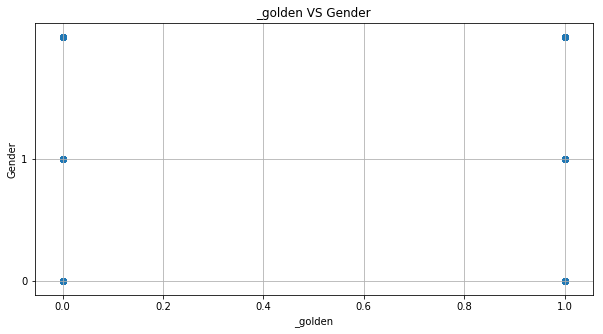

0 - (all:0_rate:1_rate:) => 6700 : 99.77611940298507 : 0.22388059701492538
1 - (all:1_rate:1_rate:) => 6194 : 99.66096222150468 : 0.3390377784953181
2 - (all:2_rate:1_rate:) => 5942 : 99.76438909458095 : 0.23561090541905083


In [87]:
# _golden特征探索
# from sklearn.feature_selection import LabelEncoder

lable_golden = preprocessing.LabelEncoder()
lable_golden.fit(['False','True'])
_golden_df_tmp = df['_golden']
array_golden = lable_golden.transform(_golden_df_tmp)
df_golden = pd.DataFrame(array_golden,columns=['_golden'])

drawScatter(df_golden, y, '_golden')

##貌似分布非常之均匀，0 1 2 对应的golden 01 分布并没有很大区别，继续看细节数据
df_golden_check = pd.concat([y, df_golden], axis=1)
golden_0 = df_golden_check[df_golden_check["gender"] == 0]._golden.count()
golden_0_1 = df_golden_check[df_golden_check["gender"] == 0]._golden.sum()
golden_0_0 = golden_0 - golden_0_1

golden_1 = df_golden_check[df_golden_check["gender"] == 1]._golden.count()
golden_1_1 = df_golden_check[df_golden_check["gender"] == 1]._golden.sum()
golden_1_0 = golden_1 - golden_1_1

golden_2 = df_golden_check[df_golden_check["gender"] == 2]._golden.count()
golden_2_1 = df_golden_check[df_golden_check["gender"] == 2]._golden.sum()
golden_2_0 = golden_2 - golden_2_1

print(f'0 - (all:0_rate:1_rate:) => {golden_0} : {golden_0_0/golden_0*100} : {golden_0_1/golden_0*100}')
print(f'1 - (all:1_rate:1_rate:) => {golden_1} : {golden_1_0/golden_1*100} : {golden_1_1/golden_1*100}')
print(f'2 - (all:2_rate:1_rate:) => {golden_2} : {golden_2_0/golden_2*100} : {golden_2_1/golden_2*100}')

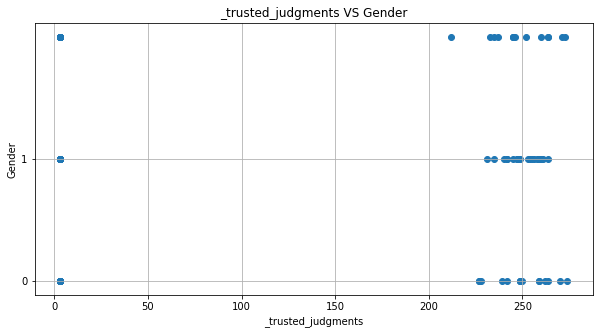

In [88]:
#从上面golden的分布来看，male=1的 这个golden金牌占比还是大一丢丢的，稍微有点差异，具体要不要加入到特征里，在看

# _trusted_judgments 特征,  always 3 for non-golden, 3是non_golden的默认值
df_trusted_judgments = df['_trusted_judgments']
df_trusted_judgments.describe()
drawScatter(df_trusted_judgments, y, '_trusted_judgments')

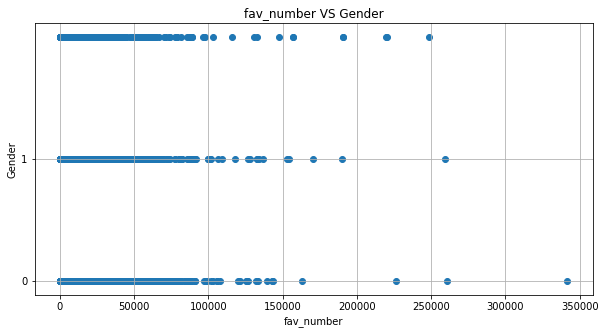

count     18836.000000
mean       4413.461563
std       12468.532705
min           0.000000
25%          13.000000
50%         482.500000
75%        3375.500000
max      341621.000000
Name: fav_number, dtype: float64

In [89]:
#继续探索其他维度的特征
drawScatter(df['fav_number'],y,'fav_number')

df['fav_number'].describe()

In [90]:
#从直观的角度来看分布，0-7000左右，差异不大
#从7000以后，female的表现大于male，大于brand，分布还是有差距的
#可以作为重点参考特征

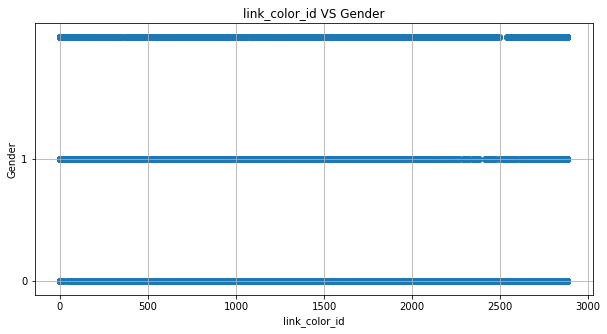

In [91]:
#针对类型类的特征，先进行编码，编码之前构建字典
dic_link_color = []
df_link_color = df['link_color']
list_link_color = df_link_color.tolist()

#构建link_color字典
for i in list_link_color:
    if i not in dic_link_color:
        dic_link_color.append(i)
    
label_link_color = preprocessing.LabelEncoder()
label_link_color.fit(dic_link_color)

df_link_color_id_tmp = label_link_color.transform(df_link_color)
df_link_color_id = pd.DataFrame(df_link_color_id_tmp, index=df.index, columns=['link_color_id'])

#查看link_color_l分布
drawScatter(df_link_color_id,y,'link_color_id')
#分布差异不大

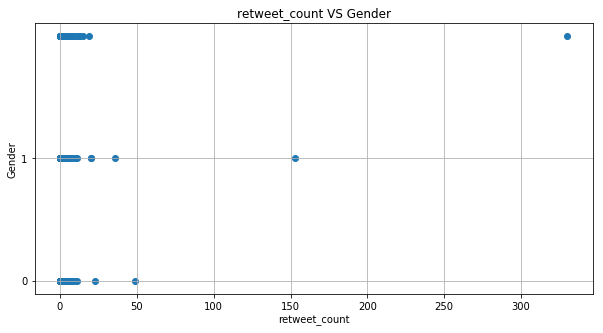

In [92]:
#retweet_count被关注次数
drawScatter(df['retweet_count'],y,'retweet_count')

#brand与female还有male存在一定程度上的分布差异

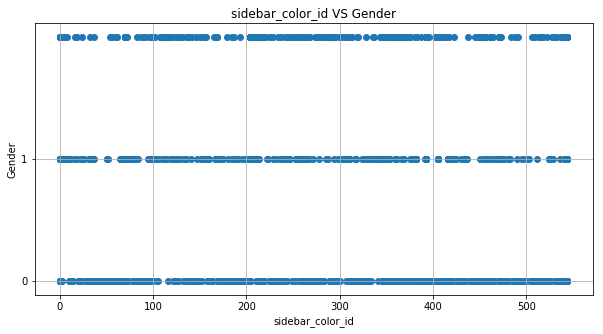

In [93]:
#sidebar_color特征
# from sklearn.feature_selection import LabelEncoder  #引入特征筛选的包

#构建link_color字典dic_sidebar_color
dic_sidebar_color = []
df_sidebar_color = df['sidebar_color']
list_sidebar_color = df_sidebar_color.tolist()

for i in list_sidebar_color:
    if i not in dic_sidebar_color:
        dic_sidebar_color.append(i)
        
#通过字典进行label编码
label_sidebar_color = preprocessing.LabelEncoder()
label_sidebar_color.fit(dic_sidebar_color)
df_sidebar_color_id_tmp = label_sidebar_color.transform(df_sidebar_color)
df_sidebar_color_id = pd.DataFrame(df_sidebar_color_id_tmp, index=df.index, columns=['sidebar_color_id'])

#调用分布绘制函数
drawScatter(df_sidebar_color_id,y,'sidebar_color_id')

#边框颜色存在分布密度不同的差异，可以重点观测该属性

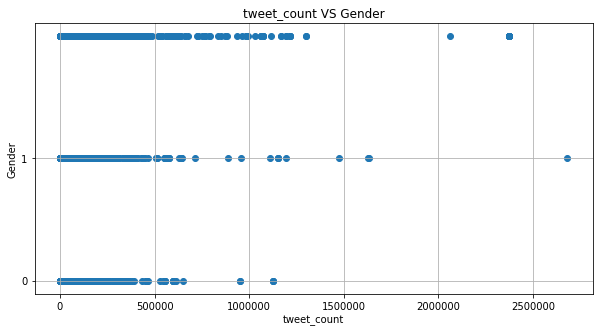

In [94]:
#tweet_count发布tweet数量
drawScatter(df['tweet_count'],y,'tweet_count')
#tweet_count特征，可以重点参考

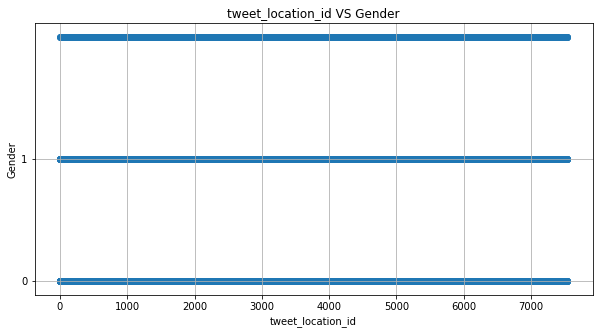

In [95]:
#tweet_location定位
df_tweet_location = df['tweet_location'].fillna('unkonwn')

dic_tweet_location = []
list_tweet_location = df_tweet_location.tolist()

for i in list_tweet_location:
    if i not in dic_tweet_location:
        dic_tweet_location.append(i)
        
label_tweet_location = preprocessing.LabelEncoder()
label_tweet_location.fit(dic_tweet_location)

df_tweet_location_id_tmp = label_tweet_location.transform(df_tweet_location)
df_tweet_location_id = pd.DataFrame(df_tweet_location_id_tmp, index=df.index, columns=['tweet_location_id'])

df_tweet_location_id.drop_duplicates('tweet_location_id').count()
#总类别个数约为1/3，进一步观测分布

drawScatter(df_tweet_location_id,y,'tweet_location_id')

#舍去该特征

In [96]:
#text与describe已经通过词的方式计算概率，另外部分特征进一步进行模型训练
#取特征如下：
# _golden 差异性很小，df值：df_golden
# _trusted_judgments特征，差异小，除了默认的3，剩余50个非3的值为差异分布，df值：df['_trusted_judgments']
# fav_number特征，存在一定程度上的全局差异，df值：df['fav_number']
# link_color特征，存在部分分布差异，df值：df_link_color_id
# retweet_count，相对显著，df值：df['retweet_count']
# sidebar_color, 相对显著，df值: df_sidebar_color_id
# tweet_count，相对显著，df值：df['tweet_count']

In [97]:
#拿到x特征集合
df_x = pd.concat([df[['_trusted_judgments','fav_number','retweet_count','tweet_count']]
                  ,df_golden
                  ,df_link_color_id
                  ,df_sidebar_color_id],axis=1)

#数据切割
x_train, x_test, y_train, y_test = train_test_split(df_x, y, test_size = 0.25)
print(f'Train : Text =>{y_train.count()} : {y_test.count()}')

df_x.describe().T

Train : Text =>14127 : 4709


,count,mean,std,min,25%,50%,75%,max
_trusted_judgments,18836.0,3.655394,12.722085,3.0,3.00,3.0,3.0,274.0
fav_number,18836.0,4413.461563,12468.532705,0.0,13.00,482.5,3375.5,341621.0
retweet_count,18836.0,0.082502,2.732317,0.0,0.00,0.0,0.0,330.0
tweet_count,18836.0,39135.700680,119130.638890,1.0,2399.75,11312.5,39793.5,2680199.0
_golden,18836.0,0.002654,0.051455,0.0,0.00,0.0,0.0,1.0
link_color_id,18836.0,816.489594,937.403143,0.0,76.00,76.0,1732.0,2881.0
sidebar_color_id,18836.0,312.381822,183.906661,0.0,226.75,352.0,405.0,544.0


In [98]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from scipy.stats import pearsonr

model_f = SelectKBest(chi2, k=3)
model_f.fit_transform(df_x, y)

df_x.info()

print(model_f.scores_)
print(model_f.pvalues_)
print(f"tweet_count - y (pearsonr):{pearsonr(df_x['tweet_count'],y)}")
print(f"retweet_count - y (pearsonr):{pearsonr(df_x['retweet_count'],y)}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18836 entries, 0 to 18835
Data columns (total 7 columns):
_trusted_judgments    18836 non-null int64
fav_number            18836 non-null int64
retweet_count         18836 non-null int64
tweet_count           18836 non-null int64
_golden               18836 non-null int64
link_color_id         18836 non-null int64
sidebar_color_id      18836 non-null int64
dtypes: int64(7)
memory usage: 1.0 MB
[8.64891987e+01 1.13400454e+07 1.88537431e+02 9.95882595e+07
 1.89903792e+00 6.14738280e+05 4.28232801e+02]
[1.65618612e-19 0.00000000e+00 1.14714140e-41 0.00000000e+00
 3.86927106e-01 0.00000000e+00 1.02430383e-93]
tweet_count - y (pearsonr):(0.11123466734351128, 6.275174261723037e-53)
retweet_count - y (pearsonr):(0.010437521513536177, 0.15201955024839234)


In [99]:
#使用万能的xgboost算法，conda安装xgboost：conda install -c  anaconda py-xgboost
from xgboost import XGBClassifier

xgb = XGBClassifier()

xgb.fit(x_train,y_train)

y_predict = xgb.predict(x_test)

other_confusion = confusion_matrix(y_test, y_predict,labels=[0,1,2])
print(f'confusion_matrix: \n{other_confusion}')

#打印各个类别的precision和recall
print_score(y_test, y_predict, other_confusion)

#效果太差，整体结果比乱猜稍微好点，比text的结果差

confusion_matrix: 
[[876 582 216]
 [480 805 237]
 [226 368 919]]
0-precision: 0.5537294563843237
0-recall: 0.5232974910394266
1-precision: 0.4586894586894587
1-recall: 0.5289093298291722
2-precision: 0.6698250728862973
2-recall: 0.6074025115664243
avg-precison: 0.5607479959866932
avg-recall: 0.5532031108116744
accuracy: 0.552134211085156


In [100]:
#尝试更换算法模型
other_nb = MultinomialNB()
other_nb.fit(x_train, y_train)
y_predict = other_nb.predict(x_test)

other_confusion = confusion_matrix(y_test, y_predict,labels=[0,1,2])
print(f'confusion_matrix: \n{other_confusion}')

print_score(y_test,y_predict, other_confusion)

#多项式分布的NB，对于male类型的分类简直是灾难

confusion_matrix: 
[[1151  145  378]
 [ 941  175  406]
 [ 558   64  891]]
0-precision: 0.43433962264150944
0-recall: 0.6875746714456392
1-precision: 0.4557291666666667
1-recall: 0.11498028909329829
2-precision: 0.5319402985074627
2-recall: 0.5888962326503635
avg-precison: 0.4740030292718796
avg-recall: 0.46381706439643366
accuracy: 0.4708005946060735


In [101]:
#更换NB的分布
#尝试更换算法模型,先更改朴素贝叶斯的分布
from sklearn.naive_bayes import GaussianNB

other_nb = GaussianNB()
other_nb.fit(x_train, y_train)
y_predict = other_nb.predict(x_test)

other_confusion = confusion_matrix(y_test, y_predict,labels=[0,1,2])
print(f'confusion_matrix: \n{other_confusion}')

print_score(y_test,y_predict, other_confusion)

#整体的结果预测，都偏向于female，整体结果太差

confusion_matrix: 
[[1561   80   33]
 [1407   81   34]
 [1178  241   94]]
0-precision: 0.3765074770863483
0-recall: 0.9324970131421745
1-precision: 0.20149253731343283
1-recall: 0.053219448094612355
2-precision: 0.5838509316770186
2-recall: 0.06212822207534699
avg-precison: 0.3872836486922666
avg-recall: 0.34928156110404457
accuracy: 0.3686557655553196


In [102]:
#更换NB的分布
#尝试更换算法模型,先更改朴素贝叶斯的分布
from sklearn.naive_bayes import BernoulliNB

other_nb = BernoulliNB()
other_nb.fit(x_train, y_train)
y_predict = other_nb.predict(x_test)

other_confusion = confusion_matrix(y_test, y_predict,labels=[0,1,2])
print(f'confusion_matrix: \n{other_confusion}')

print_score(y_test,y_predict, other_confusion)

#整体的结果预测，都偏向于female，整体结果太差, male类型几乎无法识别

confusion_matrix: 
[[1531   48   95]
 [1387   62   73]
 [ 898   38  577]]
0-precision: 0.40120545073375263
0-recall: 0.9145758661887694
1-precision: 0.4189189189189189
1-recall: 0.040735873850197106
2-precision: 0.774496644295302
2-recall: 0.3813615333773959
avg-precison: 0.5315403379826579
avg-recall: 0.44555775780545415
accuracy: 0.4608197069441495


In [103]:
#使用SVM
from sklearn.svm import SVC

other_svc = SVC()
other_svc.fit(x_train, y_train)
y_predict = other_svc.predict(x_test)

other_confusion = confusion_matrix(y_test, y_predict,labels=[0,1,2])
print(f'confusion_matrix: \n{other_confusion}')

print_score(y_test,y_predict, other_confusion)

#SVM的训练时间相对较长，整体结果偏向于female，识别度不高

confusion_matrix: 
[[1612   29   33]
 [1400   86   36]
 [1133   37  343]]
0-precision: 0.3889022919179735
0-recall: 0.9629629629629629
1-precision: 0.5657894736842105
1-recall: 0.056504599211563734
2-precision: 0.8325242718446602
2-recall: 0.2267019167217449
avg-precison: 0.5957386791489481
avg-recall: 0.4153898262987572
accuracy: 0.43342535570184754


In [104]:
#使用LR
from sklearn.linear_model  import LogisticRegressionCV

other_lr = LogisticRegressionCV()
other_lr.fit(x_train, y_train)
y_predict = other_lr.predict(x_test)

other_confusion = confusion_matrix(y_test, y_predict,labels=[0,1,2])
print(f'confusion_matrix: \n{other_confusion}')

print_score(y_test,y_predict, other_confusion)

#LRCV的结果，整体结果一般，male误判为female较多

confusion_matrix: 
[[979 340 355]
 [693 349 480]
 [477 112 924]]
0-precision: 0.45556072591903213
0-recall: 0.5848267622461171
1-precision: 0.43570536828963796
1-recall: 0.22930354796320632
2-precision: 0.5252984650369528
2-recall: 0.6107072042300066
avg-precison: 0.4721881864152076
avg-recall: 0.4749458381464433
accuracy: 0.4782331705245275


In [105]:
#使用RandomForestC
from sklearn.ensemble import RandomForestClassifier

other_rfc = RandomForestClassifier()
other_rfc.fit(x_train, y_train)
y_predict = other_rfc.predict(x_test)

other_confusion = confusion_matrix(y_test, y_predict,labels=[0,1,2])
print(f'confusion_matrix: \n{other_confusion}')

print_score(y_test,y_predict, other_confusion)

#整体结果一般，male表现一直较差

confusion_matrix: 
[[935 491 248]
 [599 678 245]
 [325 336 852]]
0-precision: 0.5029585798816568
0-recall: 0.5585424133811231
1-precision: 0.4504983388704319
1-recall: 0.4454664914586071
2-precision: 0.633457249070632
2-recall: 0.5631196298744217
avg-precison: 0.5289713892742403
avg-recall: 0.5223761782380506
accuracy: 0.5234657039711191


In [106]:
######开启参数调优之路
# + text相关的，说明text特征是有效的，可以更换算法尝试一下
# + 通text的角度看,count的特征处理+MultinomialNB的方式是text中的最佳解
# + 常规特征中,XGBClassifier和RandomForestClassifier可以进行参数调优

In [107]:
###对于text的结果进行参数调优
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

x_train, x_test, y_train, y_test = train_test_split(x_text_count, y, test_size = 0.35)

model = MultinomialNB()

alpha = [0.9,2.0]
fit_prior = [True]

param_grid = dict(alpha = alpha, fit_prior = fit_prior)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', n_jobs = 3, cv = kfold)

grid_result = grid_search.fit(x_train, y_train)

In [108]:
print("Best: %f using %s" % (grid_result.best_score_,grid_search.best_params_))

means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean,param in zip(means,params):
    print("%f  with:   %r" % (mean,param))
    
y_predict = grid_search.predict(x_test)

other_confusion = confusion_matrix(y_test, y_predict,labels=[0,1,2])
print(f'confusion_matrix: \n{other_confusion}')

print_score(y_test,y_predict, other_confusion)

Best: 0.620600 using {'alpha': 2.0, 'fit_prior': True}
0.615944  with:   {'alpha': 0.9, 'fit_prior': True}
0.620600  with:   {'alpha': 2.0, 'fit_prior': True}
confusion_matrix: 
[[1692  468  214]
 [ 799 1098  252]
 [ 321  291 1458]]
0-precision: 0.6017069701280228
0-recall: 0.7127211457455771
1-precision: 0.5912762520193862
1-recall: 0.5109353187529083
2-precision: 0.7577962577962578
2-recall: 0.7043478260869566
avg-precison: 0.6502598266478888
avg-recall: 0.642668096861814
accuracy: 0.6443197330502047


In [109]:
###常规算法中,xgboost,RandomForestClassifier进行参数调优
#拿到x特征集合
# df_x = pd.concat([df[['_trusted_judgments','fav_number','retweet_count','tweet_count']]
#                   ,df_golden
#                   ,df_link_color_id
#                   ,df_sidebar_color_id],axis=1)
from xgboost import XGBClassifier
###对于text的结果进行参数调优
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

x_train, x_test, y_train, y_test = train_test_split(df_x, y, test_size = 0.35)

model = XGBClassifier()

n_estimatores = [50,100]
max_depth = [8,12]
subsample = [0.75]
colsample_bytree = [0.75]
learning_rate = [0.1]
objective = ['multi：softmax  num_class=3']
gamma = [0, 0.2]

param_grid = dict(n_estimatores = n_estimatores
                  ,max_depth = max_depth
                  ,subsample = subsample
                  ,colsample_bytree = colsample_bytree
                  ,learning_rate = learning_rate
                  ,objective = objective
                  ,gamma = gamma)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', n_jobs = 3, cv = kfold)

grid_result = grid_search.fit(x_train, y_train)

In [110]:
print("Best: %f using %s" % (grid_result.best_score_,grid_search.best_params_))

means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
# for mean,param in zip(means,params):
#     print("%f  with:   %r" % (mean,param))
    
y_predict = grid_search.predict(x_test)

other_confusion = confusion_matrix(y_test, y_predict,labels=[0,1,2])
print(f'confusion_matrix: \n{other_confusion}')

print_score(y_test,y_predict, other_confusion)

Best: 0.546516 using {'colsample_bytree': 0.75, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimatores': 50, 'objective': 'multi：softmax  num_class=3', 'subsample': 0.75}
confusion_matrix: 
[[1264  808  286]
 [ 706 1094  337]
 [ 366  496 1236]]
0-precision: 0.541095890410959
0-recall: 0.536047497879559
1-precision: 0.4562135112593828
1-recall: 0.5119326158165652
2-precision: 0.664873587950511
2-recall: 0.5891325071496664
avg-precison: 0.5540609965402843
avg-recall: 0.5457042069485968
accuracy: 0.5451236159563173


In [111]:
from sklearn.ensemble import RandomForestClassifier
##randomforest参数调优
x_train, x_test, y_train, y_test = train_test_split(df_x, y, test_size = 0.35)

model = RandomForestClassifier()

n_estimators = [200,300]
max_depth = [8,12]
criterion = ['entropy','gini']

param_grid = dict(n_estimators = n_estimators
                  ,max_depth = max_depth
                  ,criterion = criterion)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', n_jobs = 3, cv = kfold)

grid_result = grid_search.fit(x_train, y_train)

In [112]:
print("Best: %f using %s" % (grid_result.best_score_,grid_search.best_params_))

means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
# for mean,param in zip(means,params):
#     print("%f  with:   %r" % (mean,param))
    
y_predict = grid_search.predict(x_test)

other_confusion = confusion_matrix(y_test, y_predict,labels=[0,1,2])
print(f'confusion_matrix: \n{other_confusion}')

print_score(y_test,y_predict, other_confusion)

Best: 0.542596 using {'criterion': 'gini', 'max_depth': 12, 'n_estimators': 300}
confusion_matrix: 
[[1312  657  311]
 [ 766 1087  311]
 [ 362  539 1248]]
0-precision: 0.5377049180327869
0-recall: 0.5754385964912281
1-precision: 0.47612790188348664
1-recall: 0.5023105360443623
2-precision: 0.667379679144385
2-recall: 0.5807352256863657
avg-precison: 0.5604041663535528
avg-recall: 0.5528281194073187
accuracy: 0.5531624450174427
